## Assignment 4: Computational Code and Output
**Maggie Ruan 35003185**

In [1]:
#install.packages("dplyr")
#install.packages("readr")
#install.packages("reshape")
#install.packages("corrplot")
library(readr)
library(dplyr)
library(reshape)
library(GGally)
library(corrplot)
library(glmnet)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.92 loaded

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


Loaded glmnet 4.1-7

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




### Introduction

This dataset is related to red wine of the Portuguese "Vinho Verde" wine, a unique product from the Minho (northwest) region of Portugal. The data were collected from May/2004 to February/2007 using only protected designation of origin samples that were tested at the official certification entity (CVRVV). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). The data were recorded by a computerized system (iLab), which automatically manages the process of wine sample testing from producer requests to laboratory and sensory analysis [Cortez et al., 2009]. The data set can be accessed on the UCI Machine Learning Repository at https://archive.ics.uci.edu/dataset/186/wine+quality.<br>
>Number of observations: There are a total of 1599 observations without NAs <br>
>Number of Attributes: 11 (input variables) + 1 output attribute (quality) <br>
>Name and type of variables: 
>* Input variables (All quantitative contineous variables based on physicochemical tests such as a pH tests and etc.):
   >>+ 1 - fixed acidity
   >>+ 2 - volatile acidity
   >>+ 3 - citric acid
   >>+ 4 - residual sugar
   >>+ 5 - chlorides
   >>+ 6 - free sulfur dioxide
   >>+ 7 - total sulfur dioxide
   >>+ 8 - density
   >>+ 9 - pH
   >>+ 10 - sulphates
   >>+ 11 - alcohol
>* Output variable (I changed the data type of this column to factor for future studies; the data is gathered based on sensory data that each sample was evaluated by a minimum of three sensory assessors (using blind tastes), grade the wine quality between 0 (very bad) and 10 (very excellent) and final score is given by the median of these evaluations): 
   >>+ 12 - quality (score between 0 and 10)

### Preliminary Analysis

The following codes demonstrate the steps of data cleaning and wrangling into a tidy format by omitting NAs in data set and setting the wine quality level as factor.

In [2]:
wine_red = read_csv("winequality-red.csv")
wine_red = wine_red %>%
    na.omit()%>%
    mutate(quality  = as.factor(quality))

wine_red <- wine_red %>%
  mutate(quality_group = case_when(
    quality %in% c("3", "4", "5") ~ "low",
    quality %in% c("6", "7", "8") ~ "high"
  ))

wine_red <- 
    wine_red %>% 
    mutate(quality_group = ifelse(quality_group == "high", 1, 0))

wine_red$ID = seq_len(nrow(wine_red))
head(wine_red)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_group,ID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0,1
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0,2
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0,3
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1,4
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,0,6


**Data Visualization for Preliminary Data Analysis**

By calling cor() and melt() function, we are able to visualize the correlation matrix, displaying the pairwise correlations between variables in the wine dataset that does not include the response variable (quality).

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


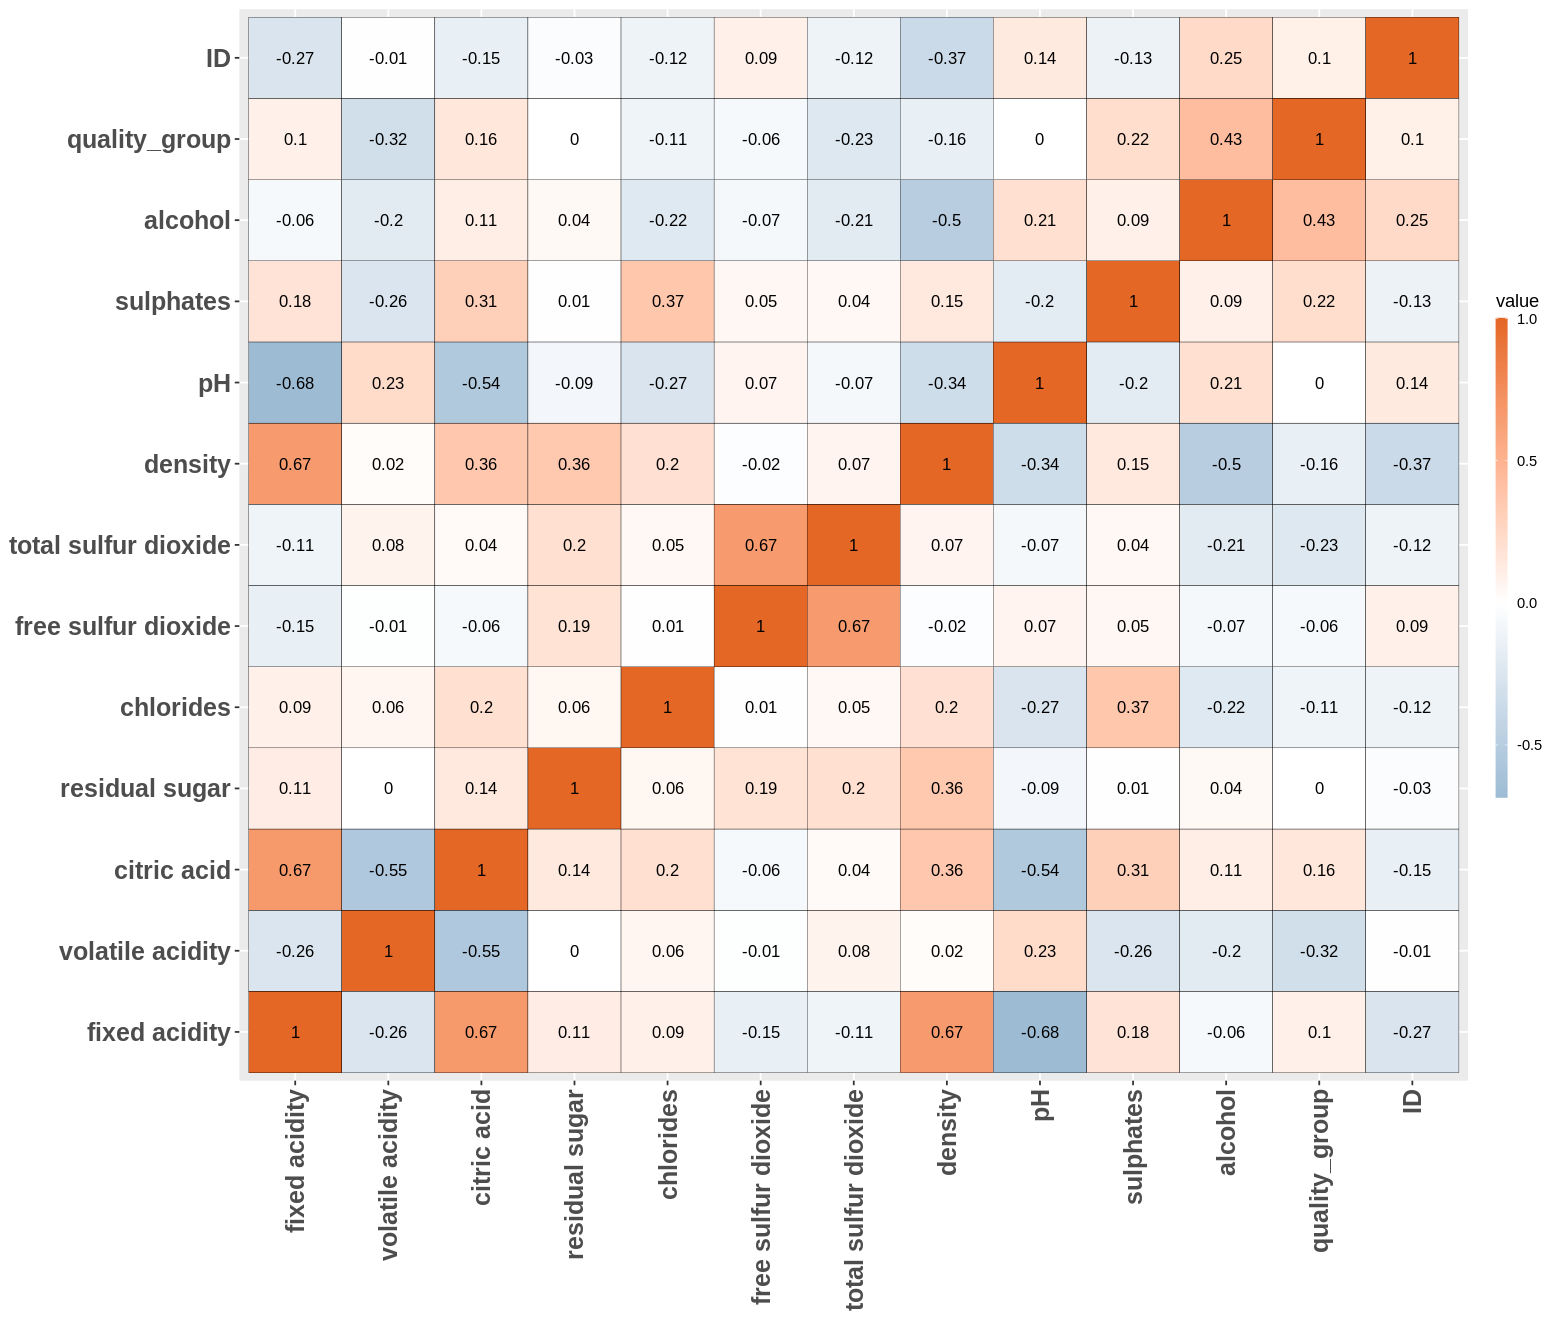

In [3]:
cor_matrix = cor(subset(wine_red, select = -c(quality)))
melted = melt(cor_matrix)

options(repr.plot.width = 13, repr.plot.height = 11)

ggplot(melted)+
    geom_tile(aes(X1, X2, fill = value), colour = "black")+
    geom_text(aes(X1, X2, label = round(value, 2)), colour = "black", size = 3.5)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
          axis.text = element_text(size = 15, face = "bold"),
          axis.title = element_blank()) +
    scale_fill_gradient2(low = "#6D9EC1", high = "#E46726")+
    guides(fill = guide_colourbar(barwidth = 0.5, barheight = 20))

From the correlation plot, positive correlations were represented by shades of red, while negative correlations were shown in shades of blue. A positive correlation implied that as one variable increased, the other variable also tended to increase. The numbers inside the boxes could be interpreted as -1, indicating a perfect negative correlation, 0 indicating no correlation, and 1 indicating a perfect positive correlation. As a result, we observed meaningful correlations in (fixed acidity and citric acid), (fixed acidity and density), (fixed acidity and pH), and (free sulfur dioxide and total sulfur dioxide) that warranted further investigation. There is a positive relationship between fixed acidity and citric acid, fixed acidity and density, and free sulfur dioxide and total sulfur dioxide, as well as a negative relationship between fixed acidity and pH.

The variable fixed acidity appeared multiple times, so there may be a large chance of having multicollinearity between variables. Prediction could possibly be worst if correlated variables are removed as there is always the bias-variance trade-off when doing so.

### Methods and Plan

**Proposed Thesis:** 

Attain a model with selected explanatory variables that predicts the response variable (quality of red wine) with the highest accuracy, employing model selection methods.

**Assumptions**

The response variable (wine quality) was recorded as integer values from 3 to 8. If treated as a categorical variable, it would have more than two levels, whereas we have only learned how to train either continuous or binary variables. Instead, I decided to group wine qualities 3, 4, and 5 as 'low quality' and 6, 7, 8 as 'high quality' to transform the response variable into a binary variable.

**Method:** 

Split the data into training and testing sets. Then, use lasso conjunction with logistic regression to assess how well the model generalizes to new data. When employing logistic regression, it assumes a linear relationship between the log-odds of the outcome and the predictor variables, with the residual to be normally distributed, the errors are independentand and the predictor variables should not exhibit high correlation with each other. Ultimately, using ROC and confusion matrix to access how well the model perform on testing data set. 
 
**Proposed limitations:**

The above result makes it challenging to determine wine quality precisely. Therefore, I have decided to treat wine quality as a continuous variable. This assumption allows me to employ backward elimination, a method that proves useful when the number of predictors is not excessively large and considers the joint effect of variables. Additionally, I will utilize ridge regression, which is suitable when there is a high degree of multicollinearity among predictors. However, the predicted outcome from the above model will likely be a numeric number with decimal places. Interpreting the result may pose challenges as we are dealing with a predictive model.

### Implementation of a proposed model

In [6]:
set.seed(301)
wine_red_train <- 
    wine_red %>% 
    slice_sample(prop = 0.7)

wine_red_test <- 
    wine_red %>% 
    anti_join(wine_red_train, by = "ID")

wine_red_train <- wine_red_train  %>% select(-ID) %>% select(-quality)
wine_red_test <- wine_red_test  %>% select(-ID)%>% select(-quality)
head(wine_red_train)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.8,0.530,0.33,2.4,0.080,24,144,0.99655,3.30,0.60,9.5,0
9.9,0.350,0.55,2.1,0.062,5,14,0.99710,3.26,0.79,10.6,0
8.4,0.745,0.11,1.9,0.090,16,63,0.99650,3.19,0.82,9.6,0
7.9,0.330,0.23,1.7,0.077,18,45,0.99625,3.29,0.65,9.3,0
6.0,0.500,0.00,1.4,0.057,15,26,0.99448,3.36,0.45,9.5,0
10.9,0.530,0.49,4.6,0.118,10,17,1.00020,3.07,0.56,11.7,1


In [9]:
set.seed(301)
model_matrix_X_train <- 
    model.matrix(quality_group~ . - 1, data = wine_red_train)

matrix_Y_train <- 
    as.matrix(wine_red_train$quality_group, ncol = 1)

wine_red_cv_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 5)

wine_red_lambda_1se_AUC_LASSO <- round(wine_red_cv_lambda_LASSO$lambda.1se, 4)
#wine_red_lambda_1se_AUC_LASSO

wine_red_LASSO_1se_AUC <- glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  lambda = wine_red_lambda_1se_AUC_LASSO
)
wine_red_LASSO_1se_AUC

coef(wine_red_LASSO_1se_AUC)


Call:  glmnet(x = model_matrix_X_train, y = matrix_Y_train, family = "binomial",      alpha = 1, lambda = wine_red_lambda_1se_AUC_LASSO) 

  Df  %Dev Lambda
1  4 20.12 0.0609

12 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)            -5.71589270
`fixed acidity`         .         
`volatile acidity`     -1.72938489
`citric acid`           .         
`residual sugar`        .         
chlorides               .         
`free sulfur dioxide`   .         
`total sulfur dioxide` -0.00213029
density                 .         
pH                      .         
sulphates               0.34227649
alcohol                 0.64649389

**Based on the result, the variable `volatile acidity`, `total sulfur dioxide`, `sulphates` and `alcohol` are selected as the final model using $\$**

Setting levels: control = 0, case = 1

Warning message in roc.default(response = matrix_Y_test, predictor = predict(wine_red_LASSO_1se_AUC, :
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases




Call:
roc.default(response = matrix_Y_test, predictor = predict(wine_red_LASSO_1se_AUC,     newx = model_matrix_X_test)[, "s0"])

Data: predict(wine_red_LASSO_1se_AUC, newx = model_matrix_X_test)[, "s0"] in 235 controls (matrix_Y_test 0) < 245 cases (matrix_Y_test 1).
Area under the curve: 0.7865

ERROR: Error in confusionMatrix(predicted, actual): could not find function "confusionMatrix"


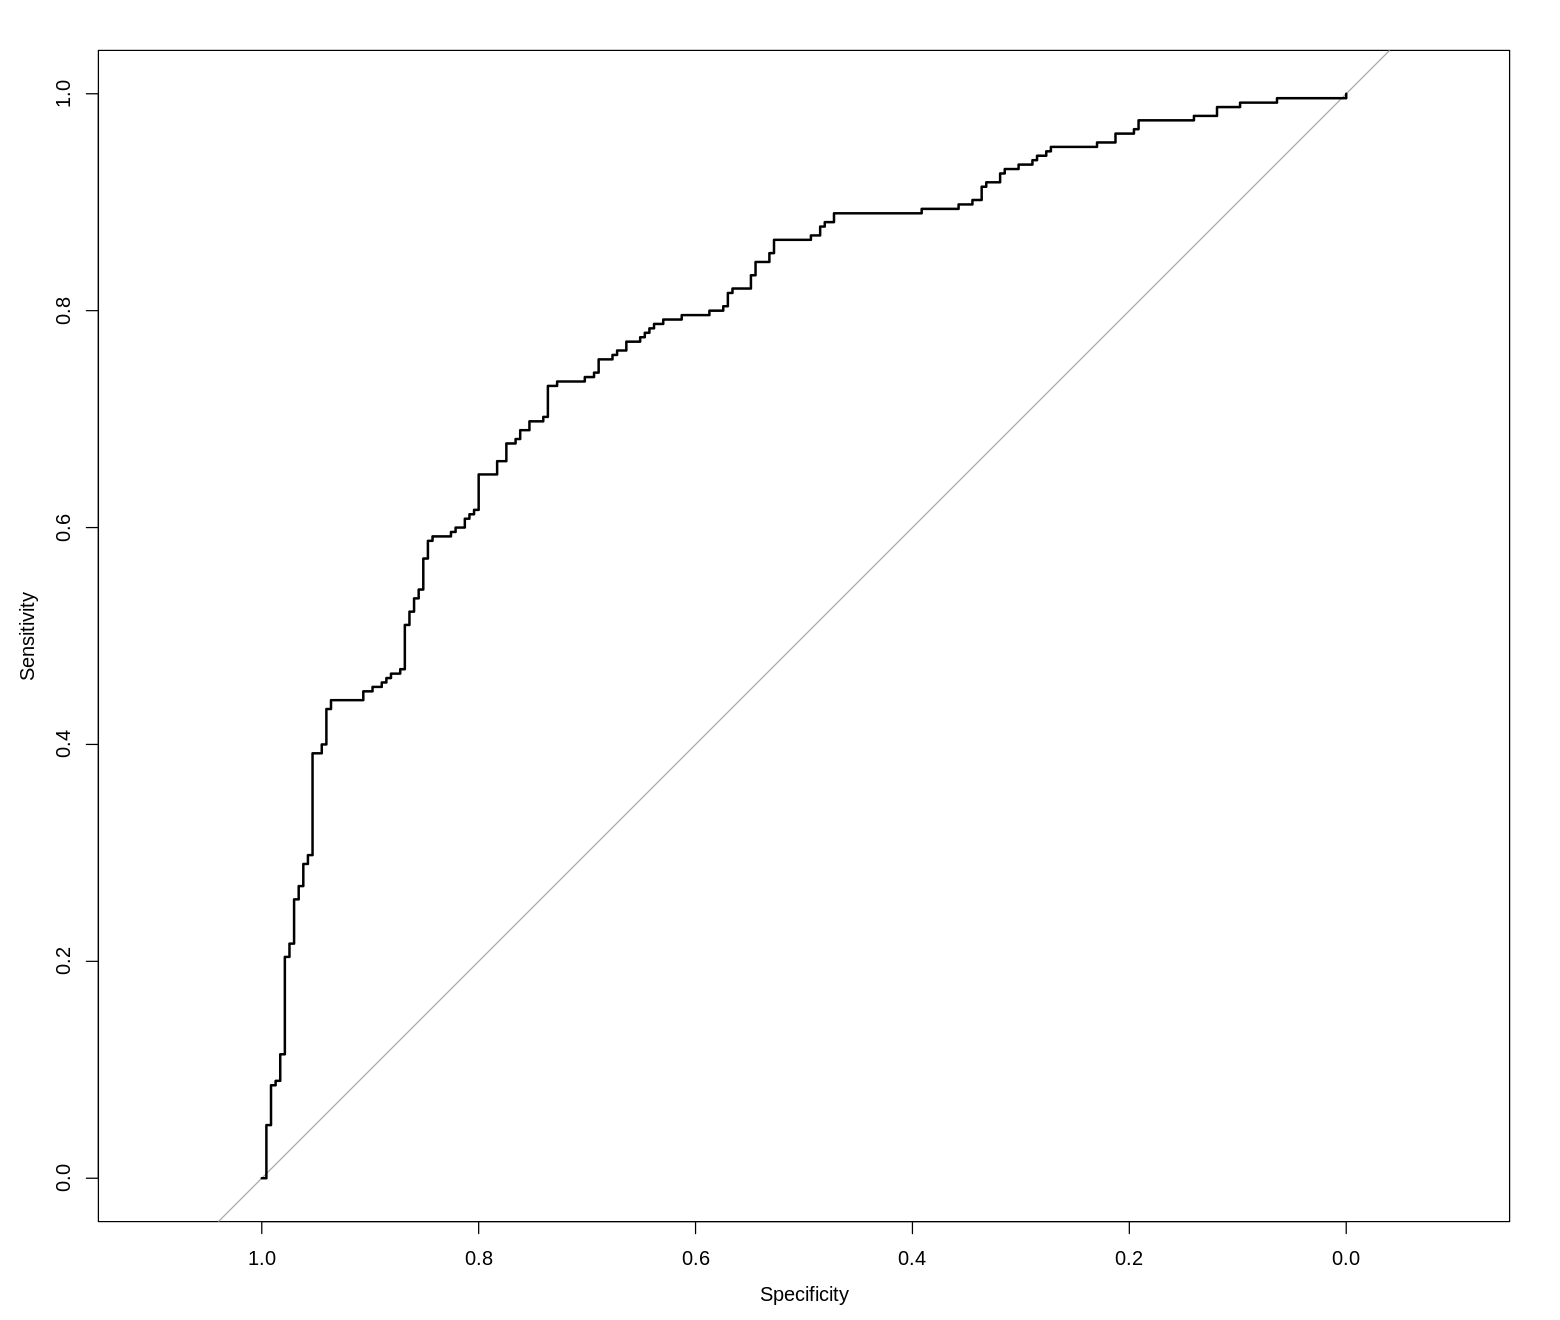

In [8]:
model_matrix_X_test <- 
     model.matrix(object = quality_group~ .,
                  data = wine_red_test)[, -1]
matrix_Y_test <- as.matrix(wine_red_test$quality_group)

ROC_lasso <- 
     roc(
         response = matrix_Y_test,
         predictor = predict(wine_red_LASSO_1se_AUC,
                      newx = model_matrix_X_test)[,"s0"] ) 
ROC_lasso
plot(ROC_lasso)

conf_matrix_caret <- confusionMatrix(predicted, actual)

The Area Under the Curve (AUC) measures the classification ability of the classifier, ranging from 0 to 1. In this case, the AUC is 0.79, which is considerably close to 1. The result is as expected since I used LASSO, which minimizes multicollinearity between variables, and employed ROC instead of a confusion matrix to avoid choosing the threshold p0.